In [17]:
import sys, os, importlib
sys.path.append('src')

from models.zoom_decam import ZoomNextDECAM

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from PIL import Image

c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
import os, shutil

src_root = "data/hyper-kvasir-labeled-images"   
target_root = "data/Hyper-Kvasir"

os.makedirs(os.path.join(target_root, "polyp"), exist_ok=True)
os.makedirs(os.path.join(target_root, "non-polyp"), exist_ok=True)

polyp_keywords = ["polyp", "dyed-lifted-polyps", "dyed-resection-margins", "ulcerative-colitis"]
non_polyp_keywords = ["normal", "esophagitis", "hemorrhoids"]

copied_polyp, copied_nonpolyp = 0, 0

for root, dirs, files in os.walk(src_root):
    folder_name = os.path.basename(root).lower()

    if any(k in folder_name for k in polyp_keywords):
        category = "polyp"
    elif any(k in folder_name for k in non_polyp_keywords):
        category = "non-polyp"
    else:
        continue  

    for fname in files:
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            src_path = os.path.join(root, fname)
            dst_path = os.path.join(target_root, category, fname)
            try:
                shutil.copy(src_path, dst_path)
                if category == "polyp":
                    copied_polyp += 1
                else:
                    copied_nonpolyp += 1
            except Exception as e:
                print("Error copying", fname, ":", e)
print(f"Polyp samples: {copied_polyp}")
print(f"Non-Polyp samples: {copied_nonpolyp}")
print(f"Total ufh: {copied_polyp + copied_nonpolyp}")


Polyp samples: 3870
Non-Polyp samples: 669
Total ufh: 4539


In [ ]:
import os, random
import torch
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class DataPreprocessing(Dataset):
    def __init__(self, root_dir, img_size=512, phase='train'):
        self.img_size = img_size
        self.phase = phase.lower()
        self.images, self.labels = [], []
        self.class_names = ['non-polyp', 'polyp']

        for lab, cls in enumerate(self.class_names):
            folder = os.path.join(root_dir, cls)
            if not os.path.isdir(folder):
                continue
            for f in os.listdir(folder):
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(folder, f))
                    self.labels.append(lab)

        if self.phase == 'train':
            self.tf = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.3),
                transforms.RandomRotation(10),
                transforms.ColorJitter(0.1, 0.1, 0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225]),
            ])
        else:
            self.tf = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
    
        pil_img = Image.open(path).convert("RGB")
        orig_img = pil_img.copy()               

        img_tensor = self.tf(pil_img)           

        label = torch.tensor(self.labels[idx]).long()

        return {
        "image": img_tensor,     
        "orig": orig_img,         
        "name": os.path.basename(path),
        "label": label
        }

    def get_input_image(self, idx):
        path = self.images[idx]
        try:
            return Image.open(path).convert("RGB")
        except:
            return Image.new("RGB", (self.img_size, self.img_size))

def create_dataloaders(root, batch_size=4, img_size=512, use_weighted_sampler=True, seed=42):

    ds_full = DataPreprocessing(root, img_size, phase='train')
    n = len(ds_full)
    if n == 0:
        raise ValueError("No images found!")

    idxs = list(range(n))
    random.seed(seed)
    random.shuffle(idxs)

    t = int(0.7 * n)
    v = int(0.85 * n)

    train_idx, val_idx, test_idx = idxs[:t], idxs[t:v], idxs[v:]

    train_ds = Subset(DataPreprocessing(root, img_size, phase='train'), train_idx)
    val_ds   = Subset(DataPreprocessing(root, img_size, phase='val'), val_idx)
    test_ds  = Subset(DataPreprocessing(root, img_size, phase='test'), test_idx)

    sampler = None
    if use_weighted_sampler:
        labels_train = torch.tensor([ds_full.labels[i] for i in train_idx])
        counts = torch.bincount(labels_train, minlength=2).float()
        class_w = 1.0 / (counts + 1e-6)
        sample_w = class_w[labels_train]
        sampler = WeightedRandomSampler(sample_w, num_samples=len(labels_train), replacement=True)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size,
        shuffle=(sampler is None), sampler=sampler,
        num_workers=0
    )

    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=0
    )

    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=0
    )

    print(f"Split: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dataloaders(
    root="data/Hyper-Kvasir",
    batch_size=4,
    img_size=512,
    use_weighted_sampler=True
)


Split: Train=3177, Val=681, Test=681


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = ZoomNextDECAM(num_classes=2, img_size=512).to(device)
ckpt = torch.load("src/models/pvtv2-b2-zoomnext.pth", map_location=device)
model.load_state_dict(ckpt, strict=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [22]:
import torch
import torch.nn as nn
total = copied_polyp + copied_nonpolyp
weights = torch.tensor([
    total / (2 * copied_nonpolyp),  
    total / (2 * copied_polyp)       
], dtype=torch.float32).to(device)

print("Class weights:", weights)

criterion = nn.CrossEntropyLoss(weight=weights)



Class weights: tensor([3.3924, 0.5864], device='cuda:0')


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
for name, param in model.global_model.backbone.named_parameters():
    param.requires_grad = False
try:
    for name, param in model.global_model.backbone.layers[-1].named_parameters():
        param.requires_grad = True
    print("Unfroze last Swin block: layers[-1]")
except AttributeError:
    print("'layers[-1]' not found — check backbone structure with:")
    print("print(model.global_model.backbone)")
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

print("Optimizer & Loss ready — training classifier + last Swin block.")


Unfroze last Swin block: layers[-1]
Optimizer & Loss ready — training classifier + last Swin block.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = ZoomNextDECAM(num_classes=2, img_size=512).to(device)
ckpt = torch.load("Swin_DECAM_finetuned.pth", map_location=device)
model.global_model.load_state_dict(ckpt["model_state"], strict=False)
print("Loaded fine-tuned Swin backbone into DECAM.")

for name, param in model.named_parameters():
    if "zoomnext_local" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

num_epochs = 3  

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch["image"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs["logits_final"]  
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f}")

print("Local ZoomNext training complete.")
torch.save({'model_state': model.state_dict()}, "Zoom_DECAM_local_finetuned.pth")
print("Saved fine-tuned local model.")


Using device: cuda
Loaded fine-tuned Swin backbone into DECAM.


Epoch 1/3: 100%|██████████| 795/795 [1:42:05<00:00,  7.70s/it]


Epoch [1/3] | Loss: 0.0707


Epoch 2/3: 100%|██████████| 795/795 [1:43:21<00:00,  7.80s/it]


Epoch [2/3] | Loss: 0.0354


Epoch 3/3: 100%|██████████| 795/795 [1:43:43<00:00,  7.83s/it]


Epoch [3/3] | Loss: 0.0289
Local ZoomNext training complete.
Saved fine-tuned local model.


In [21]:
import torch
from src.models.zoom_decam import ZoomNextDECAM

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ZoomNextDECAM(num_classes=2, img_size=512).to(device)

ckpt_global = torch.load("Swin_DECAM_finetuned.pth", map_location=device)
model.global_model.load_state_dict(ckpt_global["model_state"], strict=False)

ckpt_local = torch.load("Zoom_DECAM_local_finetuned.pth", map_location=device)
model.load_state_dict(ckpt_local["model_state"], strict=False)

print("Integrated fine-tuned Swin + ZoomNext models into DECAM.")


Integrated fine-tuned Swin + ZoomNext models into DECAM.


In [48]:
import importlib
from src.models import zoom_decam
importlib.reload(zoom_decam)
from src.models.zoom_decam import ZoomNextDECAM


In [ ]:
model.eval()
total, correct = 0, 0

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outs = model(images)  
        preds = outs["final_prediction"]  

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"\nValidation Accuracy: {100*correct/total:.2f}%")



Validation Accuracy: 99.56%


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()
combined_scores = []

with torch.no_grad():
    for batch in val_loader:  
        imgs = batch["image"].to(device)

        feats = model.global_model.backbone.forward_features(imgs)
        pooled, fmap, _ = model.global_model._pool_and_fmap(feats)

        logits = model.global_model.classifier(pooled)
        probs = F.softmax(logits, dim=1)
        entropy = -(probs * torch.log(probs + 1e-8)).sum(dim=1)

        unc_map = model.global_model._make_uncertainty_map(fmap)
        unc_mean = unc_map.mean(dim=(1, 2, 3))

        combined = 0.7 * entropy + 0.3 * unc_mean
        combined_scores.extend(combined.cpu().numpy())

combined_scores = np.array(combined_scores)
mean_c = combined_scores.mean()
std_c = combined_scores.std()
dynamic_threshold = mean_c + 1.28 * std_c  

model.zoom_entropy_threshold = dynamic_threshold
model.zoomnext_local.zoom_entropy_threshold = dynamic_threshold

print(f"\nDynamic threshold set to {dynamic_threshold:.3f}")
print(f"Mean: {mean_c:.3f}, Std: {std_c:.3f}")


all_labels, all_preds, zoom_flags = [], [], []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        outs = model(imgs)

        preds = outs["final_prediction"].cpu().numpy()
        zooms = outs["zoom_applied"].cpu().numpy().astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        zoom_flags.extend(zooms)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
zoom_flags = np.array(zoom_flags)

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, zero_division=0)
rec  = recall_score(all_labels, all_preds, zero_division=0)
f1   = f1_score(all_labels, all_preds, zero_division=0)
cm   = confusion_matrix(all_labels, all_preds)

print("\n=== TEST Results (with Dynamic Threshold) ===")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1-score : {f1*100:.2f}%")
print("\nConfusion Matrix:\n", cm)



Dynamic threshold set to 0.265
Mean: 0.204, Std: 0.048

=== TEST Results (with Dynamic Threshold) ===
Accuracy : 99.85%
Precision: 100.00%
Recall   : 99.83%
F1-score : 99.91%

Confusion Matrix:
 [[101   0]
 [  1 579]]



Category sample counts:
zoom_identified_polyp: 22
swin_identified_polyp: 558
zoom_identified_nonpolyp: 1
swin_identified_nonpolyp: 100

ZOOM_IDENTIFIED_POLYP (22)


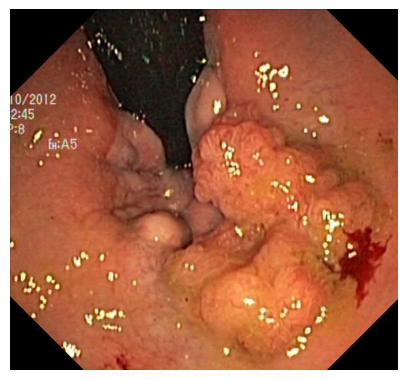

Category       : Zoom Identified Polyp
Confirmation   : Polyp
Confidence     : 1.000
Zoom Applied   : True


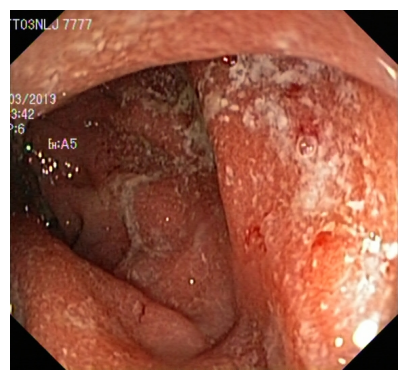

Category       : Zoom Identified Polyp
Confirmation   : Polyp
Confidence     : 0.999
Zoom Applied   : True

SWIN_IDENTIFIED_POLYP (558)


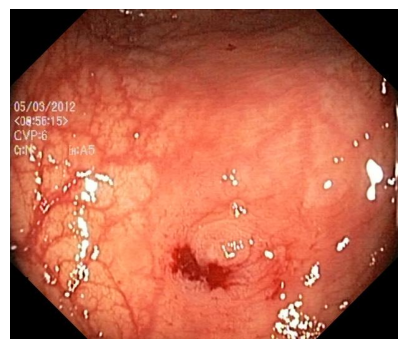

Category       : Swin Identified Polyp
Confirmation   : Polyp
Confidence     : 1.000
Zoom Applied   : False


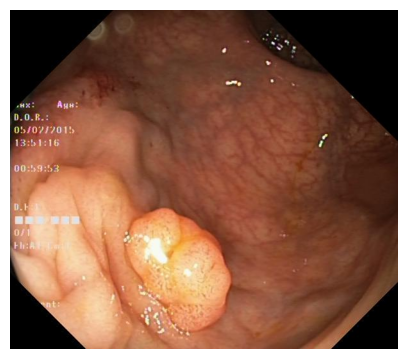

Category       : Swin Identified Polyp
Confirmation   : Polyp
Confidence     : 1.000
Zoom Applied   : False

ZOOM_IDENTIFIED_NONPOLYP (1)


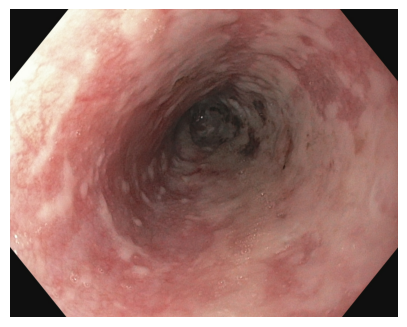

Category       : Zoom Identified Nonpolyp
Confirmation   : Non-polyp
Confidence     : 0.969
Zoom Applied   : True

SWIN_IDENTIFIED_NONPOLYP (100)


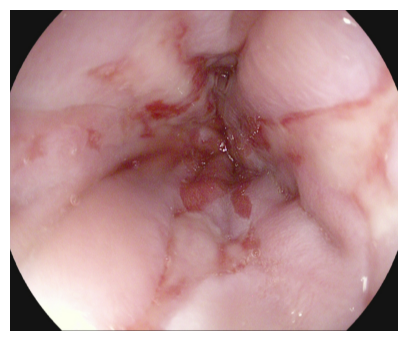

Category       : Swin Identified Nonpolyp
Confirmation   : Non-polyp
Confidence     : 1.000
Zoom Applied   : False


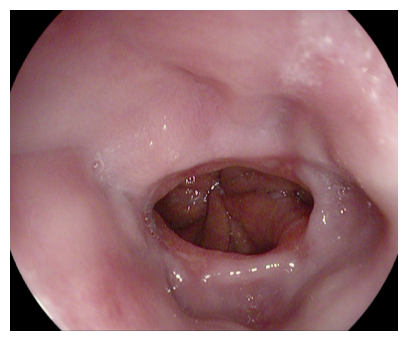

Category       : Swin Identified Nonpolyp
Confirmation   : Non-polyp
Confidence     : 1.000
Zoom Applied   : False


In [ ]:
import matplotlib.pyplot as plt
import random

test_subset = test_loader.dataset           
base_dataset = test_subset.dataset          
test_indices = test_subset.indices          

categories = {
    "zoom_identified_polyp": [],
    "swin_identified_polyp": [],
    "zoom_identified_nonpolyp": [],
    "swin_identified_nonpolyp": [],
}

model.eval()
with torch.no_grad():

    for batch_i, batch in enumerate(test_loader):
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        outs = model(imgs)
        preds = outs["final_prediction"].cpu().numpy()
        zoom_flags = outs["zoom_applied"].cpu().numpy().astype(bool)
        confs = outs["final_confidence"].cpu().numpy()

        B = len(imgs)

        for i in range(B):

            global_idx = test_indices[batch_i * test_loader.batch_size + i]

            pil_img = base_dataset.get_input_image(global_idx)

            entry = {
                "img": pil_img,
                "label": int(labels[i]),
                "pred": int(preds[i]),
                "conf": float(confs[i]),
                "zoom": bool(zoom_flags[i]),
            }

            label = entry["label"]
            zoom  = entry["zoom"]

            if label == 1 and zoom:
                categories["zoom_identified_polyp"].append(entry)
            elif label == 1 and not zoom:
                categories["swin_identified_polyp"].append(entry)
            elif label == 0 and zoom:
                categories["zoom_identified_nonpolyp"].append(entry)
            else:
                categories["swin_identified_nonpolyp"].append(entry)

def show_clean(entry, title):

    plt.figure(figsize=(5, 5))
    plt.imshow(entry["img"])
    plt.axis("off")  
    plt.show()
    confirmation = "Polyp" if entry["label"] == 1 else "Non-polyp"

    print(f"Category       : {title}")
    print(f"Confirmation   : {confirmation}")  
    print(f"Confidence     : {entry['conf']:.3f}")
    print(f"Zoom Applied   : {entry['zoom']}")

print("\nCategory sample counts:")
for k, v in categories.items():
    print(f"{k}: {len(v)}")

for cat_name, samples in categories.items():
    print(f"\n{cat_name.upper()} ({len(samples)})")

    if len(samples) == 0:
        print("No samples available")
        continue

    for entry in random.sample(samples, min(2, len(samples))):
        show_clean(entry, cat_name.replace("_", " ").title())


In [22]:
from models.swinTransformer import SwinGlobalAnalysis  
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

swin_model = SwinGlobalAnalysis(num_classes=2)
ckpt = torch.load("Swin_DECAM_finetuned.pth", map_location=device)

swin_model.load_state_dict(ckpt["model_state"], strict=False)

swin_model.to(device)
swin_model.eval()
print("Loaded fine-tuned Swin successfully!")


Loaded fine-tuned Swin successfully!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)

        logits = swin_model(imgs)["logits"]
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Swin ONLY Results:")
print("Accuracy :", accuracy_score(all_labels, all_preds))
print("Precision:", precision_score(all_labels, all_preds))
print("Recall   :", recall_score(all_labels, all_preds))
print("F1-score :", f1_score(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Swin ONLY Results:
Accuracy : 0.9970631424375918
Precision: 1.0
Recall   : 0.996551724137931
F1-score : 0.998272884283247

Confusion Matrix:
 [[101   0]
 [  2 578]]


In [ ]:
import os, shutil, random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

etis_src = "data/ETIS/images"              
etis_target = "data/ETIS_processed/polyp"  

os.makedirs(etis_target, exist_ok=True)

count = 0
for fname in os.listdir(etis_src):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        shutil.copy(os.path.join(etis_src, fname),
                    os.path.join(etis_target, fname))
        count += 1

print(f"Copied ETIS polyp images: {count}")

class ETISDataset(Dataset):
    def __init__(self, root, img_size=512):
        self.img_size = img_size
        self.images = []

        for f in os.listdir(root):
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                self.images.append(os.path.join(root, f))

        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]

        try:
            orig = Image.open(path).convert("RGB")
        except:
            orig = Image.new("RGB", (self.img_size, self.img_size))

        img = self.tf(orig)

        return {
            "image": img,     
            "orig": orig,    
            "path": path,
            "label": 1       
        }

def etis_collate(batch):
    images = torch.stack([b["image"] for b in batch])
    labels = torch.tensor([b["label"] for b in batch])
    origs = [b["orig"] for b in batch]    
    paths = [b["path"] for b in batch]

    return {
        "image": images,
        "label": labels,
        "orig": origs,
        "path": paths,
    }

def create_etis_test_loader(root, img_size=512, batch_size=4):
    ds = ETISDataset(root, img_size=img_size)

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=etis_collate
    )
    print(f"Loaded ETIS Test Samples: {len(ds)}")
    return loader

etis_loader = create_etis_test_loader(
    root="data/ETIS_processed/polyp",
    img_size=512,
    batch_size=4
)


Copied ETIS polyp images: 196
Loaded ETIS Test Samples: 196


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
class PolypOnlyDataset(Dataset):
    def __init__(self, roots, img_size=512):
        self.img_paths = []
        self.labels = []
        self.img_size = img_size

        for root in roots:
            if not os.path.exists(root):
                continue

            for f in os.listdir(root):
                if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff")):
                    self.img_paths.append(os.path.join(root, f))
                    self.labels.append(1)   # Always POLYP

        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        p = self.img_paths[idx]

        try:
            pil_img = Image.open(p).convert("RGB")
        except:
            pil_img = Image.new("RGB", (self.img_size, self.img_size))

        img = self.tf(pil_img)

        return {
            "image": img,
            "label": 1,
            "path": p    
        }

def make_loader_clinic(img_size=512, batch=4):
    roots = [
        "data/CVC-ClinicDB/PNG/Original",
        "data/CVC-ClinicDB/TIF/Original"
    ]
    ds = PolypOnlyDataset(roots, img_size)
    print(f"CVC-ClinicDB: {len(ds)} samples")
    return DataLoader(ds, batch_size=batch, num_workers=0, shuffle=False)


def make_loader_colon(img_size=512, batch=4):
    roots = ["data/CVC-ColonDB/images"]
    ds = PolypOnlyDataset(roots, img_size)
    print(f"CVC-ColonDB: {len(ds)} samples")
    return DataLoader(ds, batch_size=batch, num_workers=0, shuffle=False)

def evaluate(loader, swin_model, model, name):
    swin_model.eval()
    model.eval()

    all_labels = []
    swin_preds = []
    zoom_preds = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating {name}"):
            imgs = batch["image"].to(device)

            sw = swin_model(imgs)
            logits = sw["logits"]
            probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
            sw_pred = np.argmax(probs, axis=1)

            zo = model(imgs)
            zoom_pred = zo["final_prediction"].cpu().numpy()

            swin_preds.extend(sw_pred.tolist())
            zoom_preds.extend(zoom_pred.tolist())
            all_labels.extend([1] * len(sw_pred))     

    swin_acc = accuracy_score(all_labels, swin_preds)
    swin_f1 = f1_score(all_labels, swin_preds)

    zoom_acc = accuracy_score(all_labels, zoom_preds)
    zoom_f1 = f1_score(all_labels, zoom_preds)

    return {
        "Dataset": name,
        "Swin_Accuracy": swin_acc,
        "Swin_F1": swin_f1,
        "ZoomNext_Accuracy": zoom_acc,
        "ZoomNext_F1": zoom_f1
    }

clinic_loader = make_loader_clinic()
colon_loader = make_loader_colon()

results = []
results.append(evaluate(clinic_loader, swin_model, model, "CVC-ClinicDB"))
results.append(evaluate(colon_loader, swin_model, model, "CVC-ColonDB"))

df = pd.DataFrame(results)
print("\n\n===== FINAL RESULTS =====\n")
print(df)

df.to_csv("CVC_Swin_vs_ZoomNext.csv", index=False)
print("\nSaved: CVC_Swin_vs_ZoomNext.csv")


CVC-ClinicDB: 1224 samples
CVC-ColonDB: 380 samples


Evaluating CVC-ColonDB: 100%|██████████| 95/95 [01:16<00:00,  1.23it/s]



===== FINAL RESULTS =====

        Dataset  Swin_Accuracy   Swin_F1  ZoomNext_Accuracy  ZoomNext_F1
0  CVC-ClinicDB       0.994281  0.997132           0.995098     0.997543
1   CVC-ColonDB       0.907895  0.951724           0.923684     0.960328

Saved: CVC_Swin_vs_ZoomNext.csv


In [ ]:
def evaluate_with_conf(loader, swin_model, model, name):
    swin_model.eval()
    model.eval()

    swin_conf_list = []
    zoom_conf_list = []
    zoom_flag_list = []

    all_labels = []
    swin_preds = []
    zoom_preds = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating {name}"):
            imgs = batch["image"].to(device)

            s_out = swin_model(imgs)
            logits = s_out["logits"]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            swin_pred = probs.argmax(axis=1)
            swin_conf = probs[:, 1]  

            z_out = model(imgs)
            zoom_pred = z_out["final_prediction"].cpu().numpy()
            zoom_conf = z_out["final_confidence"].cpu().numpy()
            zoom_flag = z_out["zoom_applied"].cpu().numpy()

            swin_conf_list.extend(swin_conf.tolist())
            zoom_conf_list.extend(zoom_conf.tolist())
            zoom_flag_list.extend(zoom_flag.tolist())

            swin_preds.extend(swin_pred.tolist())
            zoom_preds.extend(zoom_pred.tolist())
            all_labels.extend([1] * len(swin_pred))  

    swin_acc = accuracy_score(all_labels, swin_preds)
    zoom_acc = accuracy_score(all_labels, zoom_preds)

    swin_f1 = f1_score(all_labels, swin_preds)
    zoom_f1 = f1_score(all_labels, zoom_preds)

    swin_avg_conf = float(np.mean(swin_conf_list))
    zoom_avg_conf = float(np.mean(zoom_conf_list))
    delta_conf = zoom_avg_conf - swin_avg_conf
    zoom_trigger_rate = float(np.mean(zoom_flag_list) * 100)

    return {
        "Dataset": name,
        "Swin_Accuracy": swin_acc,
        "Swin_F1": swin_f1,
        "ZoomNext_Accuracy": zoom_acc,
        "ZoomNext_F1": zoom_f1,

        "Swin_Avg_Conf": swin_avg_conf,
        "ZoomNext_Avg_Conf": zoom_avg_conf,
        "Delta_Conf": delta_conf,
        "Zoom_Trigger_%": zoom_trigger_rate
    }


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


def run_inference(loader, swin_model, model, name):
    swin_model.eval()
    model.eval()

    results = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Running {name}"):
            
            imgs = batch["image"].to(device)
            labels = batch["label"]                #
            origs = batch["orig"]                 

            s_out = swin_model(imgs)
            logits = s_out["logits"]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            swin_conf = probs[:, 1]
            swin_pred = np.argmax(probs, axis=1)

            z_out = model(imgs)
            zoom_pred = z_out["final_prediction"].cpu().numpy()
            zoom_conf = z_out["final_confidence"].cpu().numpy()
            zoom_flag = z_out["zoom_applied"].cpu().numpy()

            for i in range(len(origs)):
                results.append({
                    "image": origs[i],
                    "swin_pred": int(swin_pred[i]),
                    "swin_conf": float(swin_conf[i]),
                    "zoom_pred": int(zoom_pred[i]),
                    "zoom_conf": float(zoom_conf[i]),
                    "zoom_flag": bool(zoom_flag[i]),
                    "label": int(labels[i]),
                })

    print(f"{name}: {len(results)} samples processed")
    return results


In [ ]:
class PolypOnlyDataset(Dataset):
    def __init__(self, roots, img_size=512):
        self.img_paths = []
        self.img_size = img_size

        for root in roots:
            if os.path.exists(root):
                for f in os.listdir(root):
                    if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff")):
                        self.img_paths.append(os.path.join(root, f))

        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]

        try:
            img = Image.open(path).convert("RGB")
        except:
            img = Image.new("RGB", (self.img_size, self.img_size))

        img = self.tf(img)

        return {
            "image": img,
            "label": 1,      
            "path": path
        }


In [ ]:
def polyp_collate_fn(batch):
    return {
        "image": torch.stack([b["image"] for b in batch]),
        "label": torch.tensor([b["label"] for b in batch]),
        "path": [b["path"] for b in batch]
    }


In [ ]:
def make_loader_clinic(img_size=512, batch=4):
    roots = [
        "data/CVC-ClinicDB/PNG/Original",
        "data/CVC-ClinicDB/TIF/Original"
    ]
    ds = PolypOnlyDataset(roots, img_size)
    print(f"CVC-ClinicDB loaded: {len(ds)} samples")
    return DataLoader(ds, batch_size=batch, shuffle=False,
                      num_workers=0, collate_fn=polyp_collate_fn)


def make_loader_colon(img_size=512, batch=4):
    roots = ["data/CVC-ColonDB/images"]
    ds = PolypOnlyDataset(roots, img_size)
    print(f"CVC-ColonDB loaded: {len(ds)} samples")
    return DataLoader(ds, batch_size=batch, shuffle=False,
                      num_workers=0, collate_fn=polyp_collate_fn)


In [ ]:
def run_inference(loader, swin_model, model, name):
    swin_model.eval()
    model.eval()

    results = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=name):
            imgs = batch["image"].to(device)

            s_out   = swin_model(imgs)
            logits  = s_out["logits"]
            probs   = torch.softmax(logits, dim=1).cpu().numpy()
            swin_pred = probs.argmax(axis=1)
            swin_conf = probs[:, 1]

            z_out   = model(imgs)
            zoom_pred = z_out["final_prediction"].cpu().numpy()
            zoom_conf = z_out["final_confidence"].cpu().numpy()
            zoom_flag = z_out["zoom_applied"].cpu().numpy()

            paths = batch["path"] if "path" in batch else [""] * len(swin_pred)

            for i in range(len(swin_pred)):
                results.append({
                    "swin_pred": int(swin_pred[i]),
                    "swin_conf": float(swin_conf[i]),
                    "zoom_pred": int(zoom_pred[i]),
                    "zoom_conf": float(zoom_conf[i]),
                    "zoom_flag": bool(zoom_flag[i]),
                    "path": paths[i],           
                })

    return results


In [35]:
results_clinic = run_inference(clinic_loader, swin_model, model, "ClinicDB")
results_colon  = run_inference(colon_loader, swin_model, model, "ColonDB")
results_hk = run_inference(test_loader, swin_model, model, "Hyper-Kvasir")


Hyper-Kvasir: 100%|██████████| 171/171 [02:17<00:00,  1.24it/s]


In [ ]:
def compute_metrics(results, name):
    labels = [1] * len(results)

    swin_pred = [r["swin_pred"] for r in results]
    zoom_pred = [r["zoom_pred"] for r in results]

    swin_acc = accuracy_score(labels, swin_pred)
    zoom_acc = accuracy_score(labels, zoom_pred)

    swin_f1 = f1_score(labels, swin_pred, zero_division=0)
    zoom_f1 = f1_score(labels, zoom_pred, zero_division=0)

    return {
        "Dataset": name,
        "Swin_Accuracy": swin_acc,
        "Swin_F1": swin_f1,
        "ZoomNext_Accuracy": zoom_acc,
        "ZoomNext_F1": zoom_f1
    }


In [28]:
summary = []
summary.append(compute_metrics(results_hk, "Hyper-Kvasir"))
summary.append(compute_metrics(results_colon, "CVC-ColonDB"))
summary.append(compute_metrics(results_clinic, "CVC-ClinicDB"))

df = pd.DataFrame(summary)
print(df)

df.to_csv("Final_Swin_vs_ZoomNext_AllDB.csv", index=False)
print("\nSaved → Final_Swin_vs_ZoomNext_AllDB.csv")


        Dataset  Swin_Accuracy   Swin_F1  ZoomNext_Accuracy  ZoomNext_F1
0  Hyper-Kvasir       0.848752  0.918189           0.848752     0.918189
1   CVC-ColonDB       0.907895  0.951724           0.923684     0.960328
2  CVC-ClinicDB       0.994281  0.997132           0.995098     0.997543

Saved → Final_Swin_vs_ZoomNext_AllDB.csv


In [29]:
def find_corrected_cases(results):
    corrected = []
    for r in results:
        if r["swin_pred"] == 0 and r["zoom_pred"] == 1:
            corrected.append(r)
    return corrected

corr_clinic = find_corrected_cases(results_clinic)
corr_colon  = find_corrected_cases(results_colon)
corr_hk     = find_corrected_cases(results_hk)

print("Corrected (ClinicDB):", len(corr_clinic))
print("Corrected (ColonDB):", len(corr_colon))
print("Corrected (Hyper-Kvasir):", len(corr_hk))


Corrected (ClinicDB): 1
Corrected (ColonDB): 6
Corrected (Hyper-Kvasir): 0


In [30]:
def lowest_swin_case(cases):
    if len(cases) == 0:
        return None
    return sorted(cases, key=lambda x: x["swin_conf"])[0]

show_clinic = lowest_swin_case(corr_clinic)
show_colon  = lowest_swin_case(corr_colon)
show_hk     = lowest_swin_case(corr_hk)

print(show_clinic)
print(show_colon)
print(show_hk)


{'swin_pred': 0, 'swin_conf': 0.43960365653038025, 'zoom_pred': 1, 'zoom_conf': 0.9936292767524719, 'zoom_flag': True}
{'swin_pred': 0, 'swin_conf': 0.4247151017189026, 'zoom_pred': 1, 'zoom_conf': 0.5213567018508911, 'zoom_flag': True}
None


In [46]:
results_etis = run_inference(etis_loader, swin_model, model, "ETIS")

ETIS:   0%|          | 0/49 [00:00<?, ?it/s]

ETIS: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


In [47]:
def lowest_swin_case(cases):
    if len(cases) == 0:
        return None
    return sorted(cases, key=lambda x: x["swin_conf"])[0]

def show_case(case, name):
    if case is None:
        print(f"No corrected cases in {name}")
        return
    print(f"\n===== Corrected Case: {name} =====")
    print("Path:", case["path"])
    print(f"Swin : {case['swin_pred']}   Conf = {case['swin_conf']:.3f}")
    print(f"Zoom : {case['zoom_pred']}   Conf = {case['zoom_conf']:.3f}")
    print(f"Zoom Triggered = {case['zoom_flag']}")


In [ ]:
def compute_all_metrics(results, name):
    lbl = np.ones(len(results), dtype=int)

    swin = np.array([r["swin_pred"] for r in results])
    zoom = np.array([r["zoom_pred"] for r in results])

    swin_conf = np.array([r["swin_conf"] for r in results])
    zoom_conf = np.array([r["zoom_conf"] for r in results])
    swin_acc = accuracy_score(lbl, swin)
    zoom_acc = accuracy_score(lbl, zoom)

    swin_f1 = f1_score(lbl, swin)
    zoom_f1 = f1_score(lbl, zoom)
    delta_conf = float(np.mean(zoom_conf - swin_conf))
    swin_err = 1 - swin_acc
    zoom_err = 1 - zoom_acc
    if swin_err == 0:
        err_red = 0
    else:
        err_red = ((swin_err - zoom_err) / swin_err) * 100

    trigger_pct = 100 * np.mean([r["zoom_flag"] for r in results])

    return {
        "Dataset": name,
        "Swin_Accuracy": swin_acc,
        "Swin_F1": swin_f1,
        "Zoom_Accuracy": zoom_acc,
        "Zoom_F1": zoom_f1,
        "Δ Confidence": delta_conf,
        "Error_Reduction_%": err_red,
        "Zoom_Trigger_%": trigger_pct
    }


In [49]:
summary = []

summary.append(compute_all_metrics(results_hk, "Hyper-Kvasir"))
summary.append(compute_all_metrics(results_clinic, "CVC-ClinicDB"))
summary.append(compute_all_metrics(results_colon, "CVC-ColonDB"))
summary.append(compute_all_metrics(results_etis, "ETIS-LaribPolypDB"))

df = pd.DataFrame(summary)
print(df)
df.to_csv("AllDB_Swin_vs_ZoomNext_full_metrics.csv", index=False)


             Dataset  Swin_Accuracy   Swin_F1  Zoom_Accuracy   Zoom_F1  \
0       Hyper-Kvasir       0.848752  0.918189       0.975037  0.987361   
1       CVC-ClinicDB       0.994281  0.997132       1.000000  1.000000   
2        CVC-ColonDB       0.907895  0.951724       1.000000  1.000000   
3  ETIS-LaribPolypDB       0.250000  0.400000       1.000000  1.000000   

   Δ Confidence  Error_Reduction_%  Zoom_Trigger_%  
0     -0.295495          83.495146             0.0  
1     -0.175628         100.000000             0.0  
2     -0.323258         100.000000             0.0  
3      0.292693         100.000000             0.0  


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import pandas as pd
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
class PolypOnlyDataset(Dataset):
    """Loads only polyp images — binary label = 1."""
    def __init__(self, roots, img_size=512):
        self.paths = []
        self.labels = []
        self.img_size = img_size

        for r in roots:
            if not os.path.exists(r):
                print("Missing:", r)
                continue

            for f in os.listdir(r):
                if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff")):
                    self.paths.append(os.path.join(r, f))
                    self.labels.append(1)

        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        try:
            img = Image.open(p).convert("RGB")
        except:
            img = Image.new("RGB", (self.img_size, self.img_size))

        return {
            "image": self.tf(img),
            "label": 1,
            "path": p
        }

def load_clinic():
    return DataLoader(
        PolypOnlyDataset([
            "data/CVC-ClinicDB/PNG/Original",
            "data/CVC-ClinicDB/TIF/Original"
        ]),
        batch_size=4, shuffle=False
    )

def load_colon():
    return DataLoader(
        PolypOnlyDataset(["data/CVC-ColonDB/images"]),
        batch_size=4, shuffle=False
    )

def load_etis():
    return DataLoader(
        PolypOnlyDataset(["data/ETIS_processed/polyp"]),
        batch_size=4, shuffle=False
    )

def to_np(x):
    if x is None:
        return None
    return x.detach().cpu().numpy()

def run_inference(loader, name):
    swin_model.eval()
    model.eval()

    results = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating {name}"):
            imgs = batch["image"].to(device)
            s_out = swin_model(imgs)
            s_logits = to_np(s_out.get("logits"))
            s_probs  = torch.softmax(torch.tensor(s_logits), dim=1).numpy()
            s_pred   = np.argmax(s_probs, axis=1)
            s_conf   = s_probs[:, 1]
            z_out = model(imgs)

            z_pred = to_np(z_out["final_prediction"])
            z_conf = to_np(z_out["final_confidence"])
            z_flag = to_np(z_out["zoom_applied"])

            for i in range(len(s_pred)):
                results.append({
                    "swin_pred": int(s_pred[i]),
                    "swin_conf": float(s_conf[i]),
                    "zoom_pred": int(z_pred[i]),
                    "zoom_conf": float(z_conf[i]),
                    "zoom_flag": bool(z_flag[i]),
                    "label": 1
                })

    return results

def compute_all_metrics(results, name):
    lbl  = np.array([r["label"] for r in results])
    swin = np.array([r["swin_pred"] for r in results])
    zoom = np.array([r["zoom_pred"] for r in results])

    swin_conf = np.array([r["swin_conf"] for r in results])
    zoom_conf = np.array([r["zoom_conf"] for r in results])
    zoom_trig = np.array([r["zoom_flag"] for r in results])

    return {
        "Dataset": name,
        "Swin_Acc": accuracy_score(lbl, swin),
        "Swin_F1" : f1_score(lbl, swin),
        "Swin_Prec": precision_score(lbl, swin),
        "Swin_Recall": recall_score(lbl, swin),
        "Swin_AUC": roc_auc_score(lbl, swin_conf),
        "Zoom_Acc": accuracy_score(lbl, zoom),
        "Zoom_F1" : f1_score(lbl, zoom),
        "Zoom_Prec": precision_score(lbl, zoom),
        "Zoom_Recall": recall_score(lbl, zoom),
        "Zoom_AUC": roc_auc_score(lbl, zoom_conf),
        "ΔConfidence": float(np.mean(zoom_conf - swin_conf)),
        "Zoom_Trigger_%": float(100 * zoom_trig.mean())
    }

def corrected_cases(results):
    return [r for r in results if r["swin_pred"] == 0 and r["zoom_pred"] == 1]

def lowest_fixed_case(results):
    corr = corrected_cases(results)
    if len(corr) == 0:
        return None
    return sorted(corr, key=lambda x: x["swin_conf"])[0]

clinic_loader = load_clinic()
colon_loader  = load_colon()
hk_loader     = test_loader
etis_loader   = load_etis()

db_loaders = {
    "Hyper-Kvasir": hk_loader,      
    "CVC-ClinicDB": clinic_loader,
    "CVC-ColonDB": colon_loader,
    "ETIS": etis_loader
}

all_results = {}
all_metrics = []

for name, loader in db_loaders.items():
    res = run_inference(loader, name)
    all_results[name] = res
    all_metrics.append(compute_all_metrics(res, name))

df = pd.DataFrame(all_metrics)
print(df)

df.to_csv("Final_AllDB_Metrics.csv", index=False)

print("\nCorrected cases per DB:")
for name, res in all_results.items():
    print(name, "→", len(corrected_cases(res)))

print("\nLowest-confidence corrected case:")
for name, res in all_results.items():
    print(name, "→", lowest_fixed_case(res))


Evaluating Hyper-Kvasir: 100%|██████████| 171/171 [01:59<00:00,  1.44it/s]
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
Evaluating CVC-ClinicDB: 100%|██████████| 306/306 [03:41<00:00,  1.38it/s]
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.

        Dataset  Swin_Acc   Swin_F1  Swin_Prec  Swin_Recall  Swin_AUC  \
0  Hyper-Kvasir  0.848752  0.918189        1.0     0.848752       NaN   
1  CVC-ClinicDB  0.994281  0.997132        1.0     0.994281       NaN   
2   CVC-ColonDB  0.907895  0.951724        1.0     0.907895       NaN   
3          ETIS  0.250000  0.400000        1.0     0.250000       NaN   

   Zoom_Acc   Zoom_F1  Zoom_Prec  Zoom_Recall  Zoom_AUC  ΔConfidence  \
0  0.848752  0.918189        1.0     0.848752       NaN     0.150073   
1  0.995098  0.997543        1.0     0.995098       NaN     0.003169   
2  0.923684  0.960328        1.0     0.923684       NaN     0.059347   
3  0.255102  0.406504        1.0     0.255102       NaN     0.684531   

   Zoom_Trigger_%  
0        0.000000  
1        0.081699  
2        2.631579  
3        1.530612  

Corrected cases per DB:
Hyper-Kvasir → 0
CVC-ClinicDB → 1
CVC-ColonDB → 6
ETIS → 1

Lowest-confidence corrected case:
Hyper-Kvasir → None
CVC-ClinicDB → {'swin_pred': 0, 's


c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import pandas as pd
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

class PolypOnlyDataset(Dataset):
    def __init__(self, roots, img_size=512):
        self.paths = []
        self.img_size = img_size

        for r in roots:
            if not os.path.exists(r):
                print("Missing folder:", r)
                continue

            for f in os.listdir(r):
                if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff")):
                    self.paths.append(os.path.join(r, f))

        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        try:
            img = Image.open(path).convert("RGB")
        except:
            img = Image.new("RGB", (self.img_size, self.img_size))

        return {
            "image": self.tf(img),
            "label": 1,
            "path": path
        }
def load_clinic():
    return DataLoader(
        PolypOnlyDataset([
            "data/CVC-ClinicDB/PNG/Original",
            "data/CVC-ClinicDB/TIF/Original"
        ]),
        batch_size=4, shuffle=False
    )

def load_colon():
    return DataLoader(
        PolypOnlyDataset(["data/CVC-ColonDB/images"]),
        batch_size=4, shuffle=False
    )

def load_etis():
    return DataLoader(
        PolypOnlyDataset(["data/ETIS_processed/polyp"]),
        batch_size=4, shuffle=False
    )

def to_np(x):
    if x is None:
        return None
    return x.detach().cpu().numpy()

def run_inference(loader, name):
    swin_model.eval()
    model.eval()

    results = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating {name}"):

            imgs = batch["image"].to(device)
            if "label" in batch:
                labels = batch["label"].cpu().numpy()
            else:
                labels = np.ones(len(imgs))
            s_out = swin_model(imgs)
            s_logits = to_np(s_out["logits"])
            s_probs  = torch.softmax(torch.tensor(s_logits), dim=1).numpy()
            s_pred   = np.argmax(s_probs, axis=1)
            s_conf   = s_probs[:, 1]
            z_out = model(imgs)

            z_pred = to_np(z_out["final_prediction"])
            z_conf = to_np(z_out["final_confidence"])
            z_flag = to_np(z_out["zoom_applied"])
            for i in range(len(s_pred)):
                results.append({
                    "label": int(labels[i]),
                    "swin_pred": int(s_pred[i]),
                    "swin_conf": float(s_conf[i]),
                    "zoom_pred": int(z_pred[i]),
                    "zoom_conf": float(z_conf[i]),
                    "zoom_flag": bool(z_flag[i]),
                })

    return results

def compute_all_metrics(results, name):

    lbl  = np.array([r["label"] for r in results])
    swin = np.array([r["swin_pred"] for r in results])
    zoom = np.array([r["zoom_pred"] for r in results])

    swin_conf = np.array([r["swin_conf"] for r in results])
    zoom_conf = np.array([r["zoom_conf"] for r in results])
    zoom_trig = np.array([r["zoom_flag"] for r in results])

    return {
        "Dataset": name,
        "Swin_Acc": accuracy_score(lbl, swin),
        "Swin_F1" : f1_score(lbl, swin),
        "Swin_Prec": precision_score(lbl, swin),
        "Swin_Recall": recall_score(lbl, swin),
        "Swin_AUC": roc_auc_score(lbl, swin_conf),
        "Zoom_Acc": accuracy_score(lbl, zoom),
        "Zoom_F1" : f1_score(lbl, zoom),
        "Zoom_Prec": precision_score(lbl, zoom),
        "Zoom_Recall": recall_score(lbl, zoom),
        "Zoom_AUC": roc_auc_score(lbl, zoom_conf),
        "ΔConfidence": float(np.mean(zoom_conf - swin_conf)),
        "Zoom_Trigger_%": float(100 * zoom_trig.mean())
    }

def corrected_cases(results):
    return [r for r in results if r["swin_pred"] == 0 and r["zoom_pred"] == 1]

def lowest_fixed_case(results):
    corr = corrected_cases(results)
    if len(corr) == 0:
        return None
    return sorted(corr, key=lambda x: x["swin_conf"])[0]

clinic_loader = load_clinic()
colon_loader  = load_colon()
hk_loader     = test_loader      
etis_loader   = load_etis()

db_loaders = {
    "Hyper-Kvasir": hk_loader,
    "CVC-ClinicDB": clinic_loader,
    "CVC-ColonDB": colon_loader,
    "ETIS": etis_loader,
}

all_results = {}
all_metrics = []

for name, loader in db_loaders.items():
    res = run_inference(loader, name)
    all_results[name] = res
    all_metrics.append(compute_all_metrics(res, name))

df = pd.DataFrame(all_metrics)
print(df)
df.to_csv("Final_AllDB_Metrics.csv", index=False)


print("\nCorrected cases per DB:")
for name, res in all_results.items():
    print(name, "→", len(corrected_cases(res)))

print("\nLowest-confidence corrected case per DB:")
for name, res in all_results.items():
    print(name, "→", lowest_fixed_case(res))


Evaluating CVC-ClinicDB: 100%|██████████| 306/306 [03:42<00:00,  1.38it/s]
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
Evaluating CVC-ColonDB: 100%|██████████| 95/95 [01:14<00:00,  1.28it/s]
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  

        Dataset  Swin_Acc   Swin_F1  Swin_Prec  Swin_Recall  Swin_AUC  \
0  Hyper-Kvasir  0.997063  0.998273        1.0     0.996552  0.999983   
1  CVC-ClinicDB  0.994281  0.997132        1.0     0.994281       NaN   
2   CVC-ColonDB  0.907895  0.951724        1.0     0.907895       NaN   
3          ETIS  0.250000  0.400000        1.0     0.250000       NaN   

   Zoom_Acc   Zoom_F1  Zoom_Prec  Zoom_Recall  Zoom_AUC  ΔConfidence  \
0  0.997063  0.998273        1.0     0.996552  0.011702     0.150073   
1  0.995098  0.997543        1.0     0.995098       NaN     0.003169   
2  0.923684  0.960328        1.0     0.923684       NaN     0.059347   
3  0.255102  0.406504        1.0     0.255102       NaN     0.684531   

   Zoom_Trigger_%  
0        0.000000  
1        0.081699  
2        2.631579  
3        1.530612  

Corrected cases per DB:
Hyper-Kvasir → 0
CVC-ClinicDB → 1
CVC-ColonDB → 6
ETIS → 1

Lowest-confidence corrected case per DB:
Hyper-Kvasir → None
CVC-ClinicDB → {'label': 1,


c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\OneDrive\ZoomNext-Decam\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
import torch
import numpy as np
from skimage.transform import resize

def pointing_game_accuracy(cams, masks):
    correct = 0
    for cam, mask in zip(cams, masks):
        cam = cam.squeeze()
        mask = mask.squeeze()
        cam_up = resize(cam, mask.shape, order=1, preserve_range=True)
        y, x = np.unravel_index(np.argmax(cam_up), cam_up.shape)
        if mask[y, x] > 0:
            correct += 1

    return correct / len(cams)


In [28]:
import importlib
import models.cam_metrics
import utils.visualize_utils
importlib.reload(models.cam_metrics)
importlib.reload(utils.visualize_utils)
from models.cam_metrics import *


In [10]:
import sys, os
sys.path.append(os.path.abspath("src"))


In [ ]:
from utils.cam_metrics import *
from models.swinTransformer import SwinGlobalAnalysis

model = SwinGlobalAnalysis(num_classes=2).eval()

batch = next(iter(val_loader))
image = batch["image"][0].unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image = image.to(device)

out = model(image)

true_score = out["confidence"].item()
cam = out["cam_32x32"][0]     

drop, inc = average_drop_increase(model, image, cam, true_score)
del_auc, ins_auc = deletion_insertion(model, image, cam)
comp = cam_complexity(cam)
coh = cam_coherency(cam.squeeze(0))
adcc = compute_adcc(drop, inc, coh, ins_auc)

print("Average Drop:", drop)
print("Increase:", inc)
print("Deletion AUC:", del_auc)
print("Insertion AUC:", ins_auc)
print("Complexity:", comp)
print("Coherency:", coh)
print("ADCC:", adcc)


Average Drop: 0.004866182804107666
Increase: 0
Deletion AUC: 25.47766599059105
Insertion AUC: 25.340716272592545
Complexity: 166.80415
Coherency: 0.9481552913784981
ADCC: 26.161564347797594


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from models.swinTransformer import SwinGlobalAnalysis
from models.cam_metrics import average_drop_increase, deletion_insertion, cam_complexity, cam_coherency, compute_adcc

class PolypDatasetVisual(Dataset):
    def __init__(self, root_dir, img_size=512, phase='test'):
        self.root_dir = root_dir
        self.img_size = img_size
        self.phase = phase.lower()
        exts = ('.jpg', '.jpeg', '.png', '.bmp')
        self.paths = []
        for root, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith(exts):
                    self.paths.append(os.path.join(root, f))
        self.paths.sort()

        if self.phase == 'train':
            self.tf = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.3),
                transforms.RandomRotation(10),
                transforms.ColorJitter(0.1, 0.1, 0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225]),
            ])
        else:
            self.tf = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        name = os.path.basename(p)
        try:
            pil = Image.open(p).convert("RGB")
        except Exception:
            pil = Image.new("RGB", (self.img_size, self.img_size), (0,0,0))

        orig = pil.copy()
        orig = orig.resize((self.img_size, self.img_size))
        orig_np = np.array(orig)  
        img_tensor = self.tf(pil)  

        label = torch.tensor(0).long()

        return {"image": img_tensor, "orig": orig_np, "name": name, "label": label}

def denormalize_tensor(tensor):
    t = tensor.detach().cpu().float()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    t = t * std + mean
    t = t.clamp(0,1)
    np_img = (t.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return np_img

def heatmap_from_2d(arr):
    norm = np.clip(arr, 0.0, 1.0)
    heat = (255 * norm).astype(np.uint8)
    # apply colormap (OpenCV uses BGR)
    hm = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)
    return hm

def overlay_heatmap(img_rgb, heatmap, alpha=0.5):
    img_f = img_rgb.astype(np.float32) / 255.0
    hm_f  = heatmap.astype(np.float32) / 255.0
    overlay = (img_f * (1.0 - alpha) + hm_f * alpha)
    overlay = np.clip(overlay * 255.0, 0, 255).astype(np.uint8)
    return overlay

def save_pipeline_panel(out_path, columns, titles=None, dpi=150):
    n = len(columns)
    h, w = columns[0].shape[:2]

    fig_h = 3.0
    fig_w = n * (fig_h * (w/h))
    fig, axs = plt.subplots(1, n, figsize=(fig_w, fig_h), dpi=dpi)
    if n == 1:
        axs = [axs]
    for i, ax in enumerate(axs):
        ax.imshow(columns[i])
        ax.axis('off')
        if titles:
            ax.set_title(titles[i], fontsize=8)
    plt.subplots_adjust(wspace=0.01, hspace=0)
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.01)
    plt.close(fig)
def stitch_rows(row_paths, out_path):
    imgs = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in row_paths]
    heights = [img.shape[0] for img in imgs]
    widths  = [img.shape[1] for img in imgs]
    H = max(heights)
    W = max(widths)
    padded = []
    for img in imgs:
        h, w = img.shape[:2]
        canvas = np.ones((H, W, 3), dtype=np.uint8) * 255
        canvas[:h, :w, :] = img
        padded.append(canvas)
    merged = np.vstack(padded)
    merged_bgr = cv2.cvtColor(merged, cv2.COLOR_RGB2BGR)
    cv2.imwrite(out_path, merged_bgr)
def run_pipeline(
    data_root,
    save_dir="results/swin_pipeline_5rows",
    model_ckpt=None,
    img_size=512,
    batch_size=4,
    num_rows=5,
    zoom_model=None,
    device=None
):
    os.makedirs(save_dir, exist_ok=True)
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    dataset = PolypDatasetVisual(root_dir=data_root, img_size=img_size, phase='test')
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    swin = SwinGlobalAnalysis(num_classes=2, img_size=img_size, pretrained=True).to(device).eval()
    if model_ckpt:
        ck = torch.load(model_ckpt, map_location=device)
        swin.load_state_dict(ck, strict=False)
    zoom = zoom_model

    saved_rows = []
    count = 0

    for batch in tqdm(test_loader, desc="Processing test set"):
        images = batch["image"].to(device)          
        origs   = batch["orig"].numpy()            
        names   = batch["name"]                    

        with torch.no_grad():
            out = swin(images)   
        B = images.shape[0]
        for i in range(B):
            if count >= num_rows:
                break

            img_tensor = images[i]           
            orig_np = origs[i]              
            name = names[i] if isinstance(names, (list, tuple)) else str(names)

            col_orig = orig_np.copy()

            preproc_np = denormalize_tensor(img_tensor)

            cam32 = out["cam_32x32"][i]               
            if cam32.dim() == 3:
                cam32 = cam32.squeeze(0)
            cam32_np = cam32.detach().cpu().numpy()
            cam512 = cv2.resize(cam32_np, (preproc_np.shape[1], preproc_np.shape[0]), interpolation=cv2.INTER_LINEAR)
            cam_hm = heatmap_from_2d(cam512)
            cam_overlay = overlay_heatmap(preproc_np, cam_hm)

            if "uncertainty_map" in out and out["uncertainty_map"] is not None:
                u_map = out["uncertainty_map"][i]
                if u_map.dim() == 3:
                    u_map = u_map.squeeze(0)
                u_np = u_map.detach().cpu().numpy()
                u512 = cv2.resize(u_np, (preproc_np.shape[1], preproc_np.shape[0]), interpolation=cv2.INTER_LINEAR)
                u_hm = heatmap_from_2d(u512)
                u_overlay = overlay_heatmap(preproc_np, u_hm)
            else:
                u_overlay = np.ones_like(preproc_np) * 255
            if "attention_map" in out and out["attention_map"] is not None:
                att = out["attention_map"][i]
                if att.dim() == 3:
                    att = att.squeeze(0)
                att_np = att.detach().cpu().numpy()
                att512 = cv2.resize(att_np, (preproc_np.shape[1], preproc_np.shape[0]), interpolation=cv2.INTER_LINEAR)
                att_hm = heatmap_from_2d(att512)
                att_overlay = overlay_heatmap(preproc_np, att_hm)
            else:
                att_overlay = np.ones_like(preproc_np) * 255
            cy, cx = np.unravel_index(np.argmax(cam32_np), cam32_np.shape)
            H, W = preproc_np.shape[:2]
            ph = H // 4
            pw = W // 4
            center_y = int((cy / cam32_np.shape[0]) * H)
            center_x = int((cx / cam32_np.shape[1]) * W)
            top = max(0, center_y - ph//2)
            left = max(0, center_x - pw//2)
            bottom = min(H, top + ph)
            right  = min(W, left + pw)
            patch = preproc_np[top:bottom, left:right]
            if patch.size == 0:
                patch = np.ones((128,128,3), dtype=np.uint8) * 255
            else:
                patch = cv2.resize(patch, (128,128))
            if zoom is not None:
                zoom_vis = patch.copy()
            else:
                zoom_vis = np.ones((128,128,3), dtype=np.uint8) * 255

            fused = overlay_heatmap(preproc_np, cam_hm, alpha=0.6)
            titles = ["Original", "Preprocessed", "Global CAM", "Uncertainty", "Attention", "Region Patch", "ZoomNeXt", "Fused"]

            Ht, Wt = preproc_np.shape[:2]
            col_patch = cv2.resize(patch, (Wt//4, Ht//4))
            col_patch_big = cv2.resize(patch, (Wt, Ht))
            col_zoom_big  = cv2.resize(zoom_vis, (Wt, Ht))

            columns = [
                col_orig,
                preproc_np,
                cam_overlay,
                u_overlay,
                col_patch_big
            ]

            out_path = os.path.join(save_dir, f"{count:03d}_{name}")
            save_pipeline_panel(out_path + ".png", columns, titles=titles, dpi=150)
            saved_rows.append(out_path + ".png")
            true_score = out["confidence"][i].detach().cpu().item() if ("confidence" in out) else None
            try:
                drop, inc = average_drop_increase(swin, images[i].unsqueeze(0), cam32.unsqueeze(0), true_score)
                del_auc, ins_auc = deletion_insertion(swin, images[i].unsqueeze(0), cam32.unsqueeze(0))
            except Exception as e:
                del_auc, ins_auc, drop, inc = None, None, None, None

            try:
                comp = cam_complexity(cam32.detach().cpu())
                coh = cam_coherency(cam32.detach().cpu())
                adcc = compute_adcc(drop if drop is not None else 0.0,
                                    inc if inc is not None else 0.0,
                                    coh if coh is not None else 0.0,
                                    ins_auc if ins_auc is not None else 0.0)
            except Exception:
                comp, coh, adcc = None, None, None

            print(f"[{count}] saved {out_path}.png  conf={true_score:.3f}  ADCC={adcc}")

            count += 1
            if count >= num_rows:
                break

        if count >= num_rows:
            break
    print("Done. Panels saved to:", save_dir)
    return saved_rows

if __name__ == "__main__":
    DATA_ROOT = "data/Hyper-Kvasir"          
    SAVE_DIR  = "results/swin_pipeline_5rows"
    MODEL_CKPT = None                        
    IMG_SIZE = 512
    BATCH_SIZE = 4
    NUM_ROWS = 10

    zoom_model = None

    run_pipeline(
        data_root=DATA_ROOT,
        save_dir=SAVE_DIR,
        model_ckpt=MODEL_CKPT,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        num_rows=NUM_ROWS,
        zoom_model=zoom_model
    )


Processing test set:   0%|          | 0/1135 [00:00<?, ?it/s]

[0] saved results/swin_pipeline_5rows\000_01577b97-7e95-48a9-b722-0da9d2cca313.jpg.png  conf=0.537  ADCC=0.8889493406330973
[1] saved results/swin_pipeline_5rows\001_018fc250-a81a-41c0-83af-0521dc455d26.jpg.png  conf=0.502  ADCC=0.9185409752067565
[2] saved results/swin_pipeline_5rows\002_029e4210-dcc0-4350-92e4-9bd075ca31df.jpg.png  conf=0.522  ADCC=0.9228532445532631


Processing test set:   0%|          | 1/1135 [00:02<50:18,  2.66s/it]

[3] saved results/swin_pipeline_5rows\003_02cefcd3-32ca-49fb-b7c7-c174e2683c00.jpg.png  conf=0.514  ADCC=0.9139946533237185
[4] saved results/swin_pipeline_5rows\004_02faf76d-2d43-41be-a56d-3e7776e08144.jpg.png  conf=0.537  ADCC=0.9323371034014101
[5] saved results/swin_pipeline_5rows\005_035e1df9-eeb6-4b52-9acf-43b3a7be0409.jpg.png  conf=0.527  ADCC=0.9015395178643923
[6] saved results/swin_pipeline_5rows\006_03fac64b-d4da-4f5c-a78f-091682c809ca.jpg.png  conf=0.509  ADCC=0.916366426423742


Processing test set:   0%|          | 2/1135 [00:05<48:40,  2.58s/it]

[7] saved results/swin_pipeline_5rows\007_0455371c-4047-4867-be17-453a17fdf1ed.jpg.png  conf=0.501  ADCC=0.9233893883276563
[8] saved results/swin_pipeline_5rows\008_04aacb46-a467-44e3-955f-206d0373691f.jpg.png  conf=0.510  ADCC=0.9180080873360515


Processing test set:   0%|          | 2/1135 [00:06<1:04:48,  3.43s/it]

[9] saved results/swin_pipeline_5rows\009_058e672c-ec30-4eb2-8921-a7a8bda1c268.jpg.png  conf=0.523  ADCC=0.9156705869064312
Done. Panels saved to: results/swin_pipeline_5rows


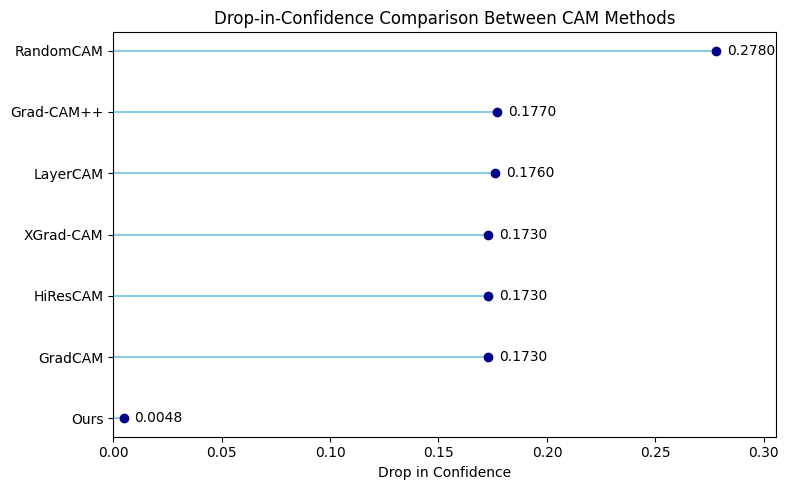

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = {
    "Method": [
        "GradCAM", "HiResCAM", "Grad-CAM++",
        "XGrad-CAM", "LayerCAM", "RandomCAM", "Ours"
    ],
    "Drop in Confidence": [
        0.173, 0.173, 0.177, 0.173, 0.176, 0.278, 0.0048
    ]
}

df = pd.DataFrame(data)

df_sorted = df.sort_values("Drop in Confidence")

y_pos = np.arange(len(df_sorted))
plt.figure(figsize=(8, 5))
plt.hlines(y=y_pos, xmin=0, xmax=df_sorted["Drop in Confidence"],
           color="skyblue")
plt.plot(df_sorted["Drop in Confidence"], y_pos, "o", color="darkblue")

plt.yticks(y_pos, df_sorted["Method"])
plt.xlabel("Drop in Confidence")
plt.title("Drop-in-Confidence Comparison Between CAM Methods")
plt.xlim(0, max(df_sorted["Drop in Confidence"]) * 1.1)

for x, y in zip(df_sorted["Drop in Confidence"], y_pos):
    plt.text(x + 0.005, y, f"{x:.4f}", va="center")

plt.tight_layout()
plt.show()


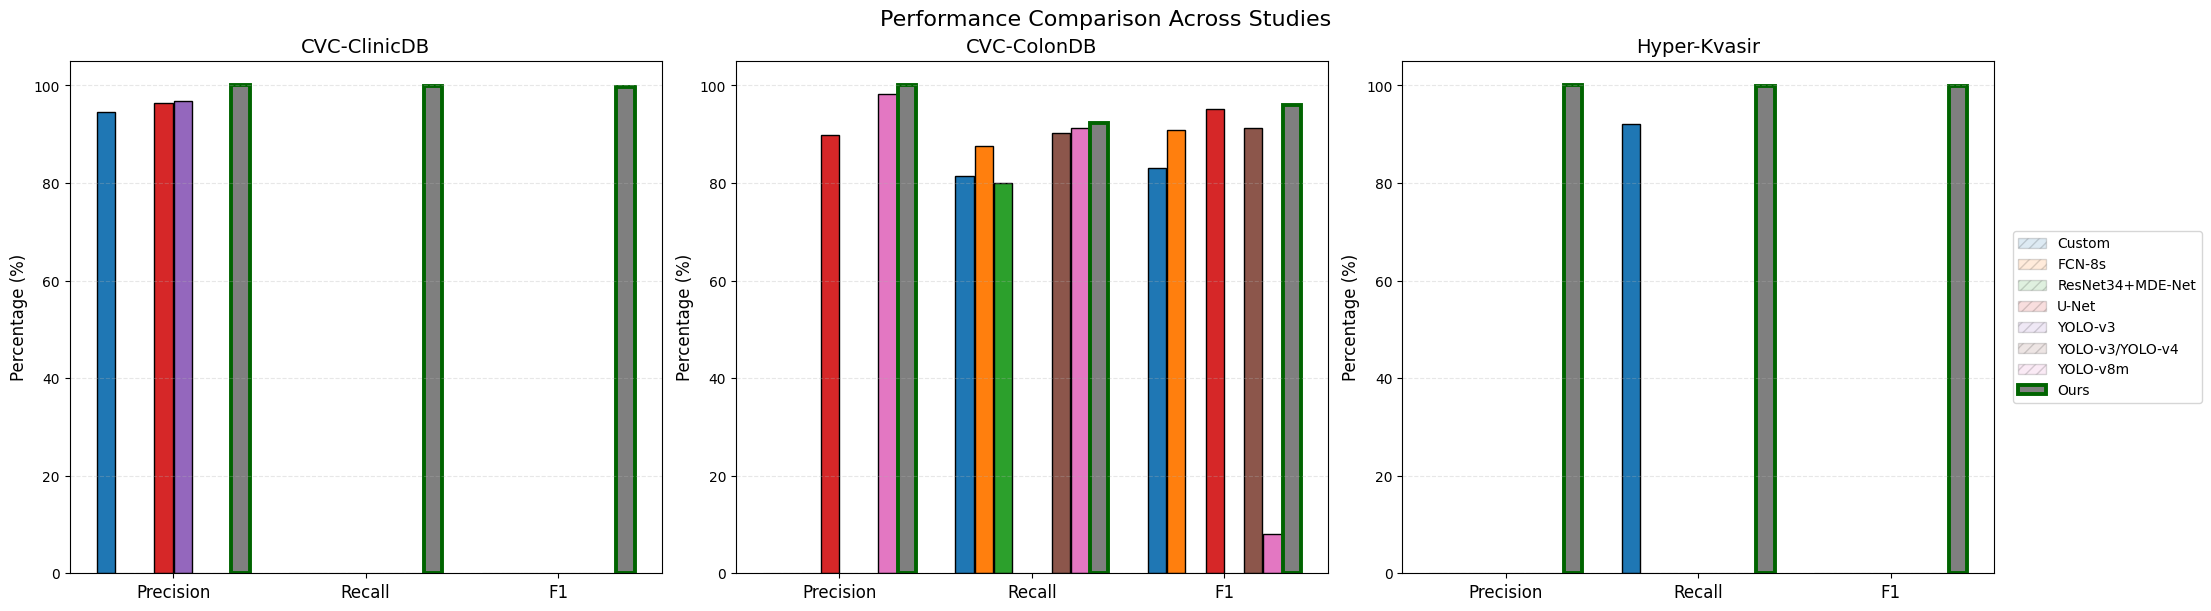

Saved: architecture_comparison.png


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

rows = [
    {"Study":"Akbari et al.", "Architecture":"Custom", "Clinic_Precision":94.6, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":80.77, "Colon_F1":np.nan,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Zhang et al.", "Architecture":"ResNet34+MDE-Net", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":80.07, "Colon_F1":np.nan,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Urban et al.", "Architecture":"YOLO-v3", "Clinic_Precision":96.9, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":np.nan, "Colon_F1":np.nan,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Lee et al.", "Architecture":"Custom", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":np.nan, "Colon_F1":94.8,
     "Hyper_Precision":np.nan, "Hyper_Recall":92.14, "Hyper_F1":np.nan},
    {"Study":"Xu et al.", "Architecture":"YOLO-v3/YOLO-v4", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":90.19, "Colon_F1":91.3,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Liu et al.", "Architecture":"U-Net", "Clinic_Precision":96.4, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":89.88, "Colon_Recall":np.nan, "Colon_F1":95.1,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Pacal & Karaboga", "Architecture":"FCN-8s", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":87.66, "Colon_F1":90.8,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Li et al. [29]", "Architecture":"Custom", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":82.85, "Colon_F1":75.7,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Li et al. [30]", "Architecture":"Custom", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":94.12, "Colon_F1":79.4,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Qadir et al.", "Architecture":"Custom", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":np.nan, "Colon_Recall":68.25, "Colon_F1":82.4,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Nogueira-Rodriguez et al.", "Architecture":"YOLO-v8m", "Clinic_Precision":np.nan, "Clinic_Recall":np.nan, "Clinic_F1":np.nan,
     "Colon_Precision":98.3, "Colon_Recall":91.25, "Colon_F1":7.99,
     "Hyper_Precision":np.nan, "Hyper_Recall":np.nan, "Hyper_F1":np.nan},
    {"Study":"Our Study (Swin–ZoomNeXt)", "Architecture":"Ours", "Clinic_Precision":100.0, "Clinic_Recall":99.95, "Clinic_F1":99.75,
     "Colon_Precision":100.0, "Colon_Recall":92.36, "Colon_F1":96.03,
     "Hyper_Precision":100.0, "Hyper_Recall":99.83, "Hyper_F1":99.91}
]

df = pd.DataFrame(rows)

grouped = df.groupby("Architecture").mean(numeric_only=True)

order = [a for a in grouped.index if a != "Ours"] + ["Ours"]
grouped = grouped.reindex(order)

metrics = ["Precision", "Recall", "F1"]
datasets = [("Clinic", "CVC-ClinicDB"), ("Colon", "CVC-ColonDB"), ("Hyper", "Hyper-Kvasir")]

n_arch = len(grouped)
x = np.arange(len(metrics))

fig, axes = plt.subplots(1, 3, figsize=(22, 6), constrained_layout=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ax, (pref, title) in zip(axes, datasets):
    bar_width = 0.8 / n_arch
    offsets = (np.arange(n_arch) - (n_arch-1)/2) * bar_width

    for i, arch in enumerate(grouped.index):
        vals = [
            grouped.loc[arch, f"{pref}_Precision"],
            grouped.loc[arch, f"{pref}_Recall"],
            grouped.loc[arch, f"{pref}_F1"]
        ]

        vals = np.array(vals, dtype=float)

        bars = ax.bar(
            x + offsets[i], 
            np.nan_to_num(vals, nan=0.0), 
            width=bar_width * 0.95,
            label=arch,
            color=colors[i % len(colors)],
            edgecolor='black'
        )

        if arch == "Ours":
            for b in bars:
                b.set_linewidth(2.8)
                b.set_edgecolor('#006400')
                b.set_alpha(1.0)

        mask = ~np.isnan(vals)
        for j, b in enumerate(bars):
            if not mask[j]:
                b.set_alpha(0.15)
                b.set_hatch('///')

    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_ylim(0, 105)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

axes[-1].legend(bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=10)
fig.suptitle("Performance Comparison Across Studies", fontsize=16)

plt.savefig("architecture_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: architecture_comparison.png")


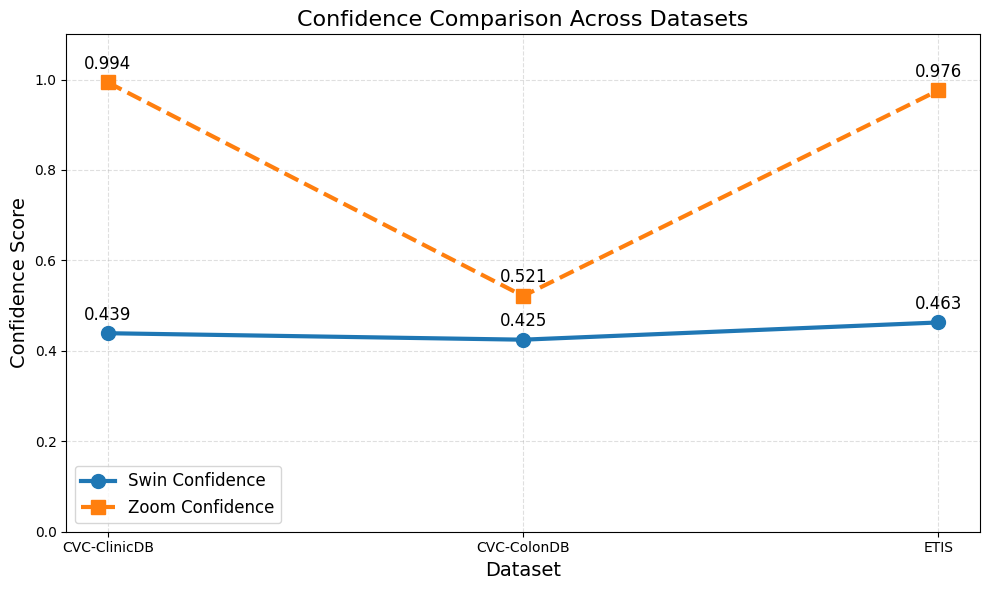

In [ ]:
import matplotlib.pyplot as plt

datasets = ["CVC-ClinicDB", "CVC-ColonDB", "ETIS"]
swin_conf = [0.4390, 0.4247, 0.4628]
zoom_conf = [0.9936, 0.5213, 0.9762]

plt.figure(figsize=(10, 6))

plt.plot(datasets, swin_conf, 'o-', linewidth=3, markersize=10, label="Swin Confidence")
plt.plot(datasets, zoom_conf, 's--', linewidth=3, markersize=10, label="Zoom Confidence")

plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Confidence Score", fontsize=14)
plt.title("Confidence Comparison Across Datasets", fontsize=16)

plt.grid(True, linestyle="--", alpha=0.4)
plt.ylim(0, 1.1)

for i, v in enumerate(swin_conf):
    plt.text(i, v + 0.03, f"{v:.3f}", ha='center', fontsize=12)

for i, v in enumerate(zoom_conf):
    plt.text(i, v + 0.03, f"{v:.3f}", ha='center', fontsize=12)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
